# CS5014 Machine Learning 

##### Practical 1 
##### Credits: 50% of the coursework

##### Deadline: 12/03/2025


_Note that MMS is the definitive source for deadlines and weights._

## Aims


The objectives of this assignment are:

* deepen your understanding of linear regression and logistic regression
* gain experience in implementing learning algorithms 
* gain experience in evaluating machine learning algorithms


## Set-up

You are **only allowed** to use the following imported packages for this practical. No off-the-shelf machine learning packages such as _scikit-learn_ are allowed. 


In [3]:
# if you use jupyter-lab, switch to %matplotlib inline instead
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    
from autograd import hessian
import autograd.numpy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd

The following method computes the gradient of a given function $f$ at an input location `initial`. Note that the finite difference method suffers from truncating and rounding errors and can be slow for large-scale machine learning models. It should never be directly used in a gradient descent algorithm. But it can be very useful to check your gradient derivation and implementation. You should always check your gradients before using them.

In [17]:
def finite_difference_gradient(f, initial, eps=1e-6):
    initial = np.array(initial, dtype=float)
    n = len(initial)
    output = np.zeros(n)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1
        ## debugging
        print("initial:", initial)
        print("ei: ", ei)
        ## / debugging
        f1 = f(initial + eps * ei)
        f2 = f(initial - eps * ei)
        print("f1: ", f1)
        output[i] = (f1-f2)/(2*eps)
    output = output.reshape(n,1)
    return output

## Question 1 (Lasso regression)


In this question, we are going to investigate Lasso regression. You are going to implement a gradient descent based learning algorithm for Lasso. Then use the implemented algorithm to find out what features are truely relevant in predicting the target. 

The dataset $\{\mathbf{x}^{(i)}, y^{(i)}\}$ is imported below for you:
* the input design matrix `d1X` contains ``n=200`` observations and each $\mathbf{x}^{(i)}$ has ``m=200`` features 
* and the last column is the regression targets ${y}^{(i)}$ (and they are stored in `d1Y`)
* among the 200 features, however, only three of them are relevant to the target $y$; and the rest 197 features are random noises
* you may assume the bias term is zero for this question



In [5]:
# read in dataset1
dataset1_df = pd.read_csv('./datasets/dataset1.csv', header=0)
dataset1 = np.array(dataset1_df)
d1X, d1Y = dataset1[:, 0:200], dataset1[:, -1]

### Task 1.1


Recall that Lasso regression's loss function is defined as  


$$L(\mathbf{w}) = \frac{1}{2n} \sum_{i=1}^n (y^{(i)} - \mathbf{w}^{\top}\mathbf{x}^{(i)})^2 + \lambda \sum_{j=1}^m |w_j|,$$
where $\lambda >0$ is the penalty coefficient

* give the gradient expression for $\mathbf{w}$
* then implement a gradient descent based algorithm to learn the parameter

*Hint: To deal with sub-gradient descent properly, you may need to do the following: when the learning process is about to converge (e.g. after certain number of iterations)* 
1. *use a diminishing learning rate, e.g.* $\gamma_t = \frac{\gamma}{\sqrt{t}}$
2. *if any weight switches signs during the learning process, set the weight to zero directly*
3. *soft-thresholding, set a small constant e.g. $\epsilon = 10^{-5}$, if any weight's absolute value drops below $\epsilon$, set it to zero directly*;
*You can do either 2 or 3 (or both).*

#### Answer Task 1.1
The gradient expression for $\mathbf{w}$ $$\large
	\mathbf{w}_{Lasso} = (\mathbf{X}^\top\mathbf{X} + n\lambda \mathbf{sign(w)})^{-1} \mathbf{X}^\top\mathbf{y}$$


In [6]:
# Implement a gradient descent algorithm
#np.sign handles sign stuff
# apparently because this is a subgradient i need to solve it in iterative approaches 

### Task 1.2 

A special property of Lasso regression is sparsity. That means, if a proper penalty parameter is used, irrelevant input features' parameters will become zero. And this sparsity property can be used to find out which input features are important or relevant. In this task, you are going to use the algorithm implemented in Task 1.1 to investigate which three of the input dimensions are truly relevant in terms of predicting the targets $y$. 

* plot the full regularisation path of $\hat{\mathbf{w}}(\lambda)$ for a range of penalty parameter $\lambda$


* use the plot to tell which features are relevant and what are their cooresponding weights?

*Hint:*
1. *To find out the relevant features, you should try different $\lambda$s and find the whole regularisation path; $\ln\lambda \in [-8:0]$ seems appropriate*;
2. *It is a good idea to fit Lasso with $\lambda$s in an ascending order; since we know as $\lambda$ increases, more weight $\hat{\mathbf{w}}(\lambda_t)$ will become sparse*; 
3. *Instead of initialising the weight randomly for the gradient descent, you may "warm start" the algorithm with the learnt parameter with a smaller $\lambda$;*


In [7]:
### report your results

## Question 2 (Logistic regression)

In this question, we are going to implement a logistic regression model to do binary classification on a simulated dataset. The dataset's input feature are four-dimensional vectors $\mathbf{x}^{(i)} \in \mathbb{R}^4$ and as expected the targets are binary, *i.e.* $y^{(i)} \in \{0, 1\}$. 


The dataset $\{\mathbf{x}^{(i)}, y^{(i)}\}$ is imported below for you:
* ``dataset2``: 2000 observations and each input $\mathbf{x}$ has 4 features 
* and the last column is the target ${y}^{(i)}$
* the dataset is then split into training and testing parts

In [8]:
# read in dataset2
dataset2_df = pd.read_csv('./datasets/dataset2.csv', header=0)
dataset2 = np.array(dataset2_df)
d2X, d2Y = dataset2[:, 0:4], dataset2[:, -1]
# split the data into training and testing 
# the training dataset has the first 1500 observation; 
# in practice, you should randomly shuffle before the split
d2_xtrain, d2_ytrain = d2X[0:1500, :], d2Y[0:1500]
# the testing dataset has the last 500
d2_xtest, d2_ytest = d2X[1500:, :], d2Y[1500:]

### Task 2.1 Implementation of logistic regression

Your task here is to implement a gradient descent based algorithm to train a logistic regression model. For this task, you cannot use `autograd`'s auto-differentiation method (*i.e.* the imported `grad` method). You will be guided to finish the task step by step. 

First, implement the `sigmoid` function:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Second, implement the cross-entropy loss and its gradient. You may want to refer to the lecture slides for the details. Recall the binary **C**ross **E**ntropy (CE) _loss_ is 


$$
L(\mathbf{w}, b)=  -\frac{1}{n}\sum_{i=1}^n {y^{(i)}} \ln \sigma^{(i)}+ (1- y^{(i)}) \ln (1-\sigma^{(i)})
$$

where $\sigma^{(i)} =\sigma(\mathbf{w}^\top\mathbf{x}^{(i)} + b).$

### 2.1 Answer. 
The loss in matrix form is  $$J(\mathbf{y}, \hat{\mathbf{y}}) = -\frac{1}{n}\left[\,\mathbf{y}^{T}\ln(\sigma) + (\mathbf{1}-\mathbf{y})^{T}\ln(\mathbf{1}-\sigma)\,\right]$$

The gradient for cross entropy loss is $$\large
\nabla \ell(\mathbf{w}) =-\frac{1}{n} \mathbf{X}^\top (\mathbf{y} - \boldsymbol{\sigma})$$

In [43]:
def cross_entropy_loss_with_gradient(w, b, X, y):
    '''
    y -> n x 1
    x -> n x m 
    w -> m x 1
    b -> float
    Output: 
    loss = float
    gradient -> n x 1
    '''
    # Number of samples
    #n = X.size
    n = X.shape[0]
    # Compute sigmoid function 
    temp = np.dot(X, w) + b
    #sigma = sigmoid(X @ w + b)
    sigma = sigmoid(temp)

    # Debug a little
    # print("w shape: ", w.shape)
    # print("X shape: " , X.shape)
    # print("y shape: ", y.shape)
    # print("sigma shape: " , sigma.shape)
    ## compute the loss 
    #error = y.T @ np.log(sigma) + (1-y).T @ np.log(1 - sigma)
    error = - y.T @ np.log(sigma) - (1-y.T) @ np.log(1 - sigma)
    loss = (np.sum(error)) / n
	## compute the gradient w.r.t w and b
    gradient = - (1/n) * (X.T @ (y - sigma))
    # print("Gradient shape: ", gradient.shape)
	## return the loss and the required gradients
    return loss, gradient

In [55]:
# TODO get rid of this - testing cross_entropy_loss_with_gradient()
# Test parameters
# w = np.array([[0.5], [-0.5]])  
# b = 1          
# X = np.array([[1.0, -1.0],
#               [0.5,  0.0],
#               [0.5,  1.5]]) 
# y = np.array([[1], [0], [1]])  

X = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])  
y = np.array([0, 0, 0, 1, 1, 1])  
w = np.array([1,1])
b = -3                                         


# Test your function
loss, gradient = cross_entropy_loss_with_gradient(w, b, X, y)

print("Cross Entropy Loss:", loss)
print(gradient)

Cross Entropy Loss: 0.36686678640551745
[-0.207 -0.144]


Now, implement the gradient descent algorithm below. Before that, you should consider testing our gradient implementation before using it in the training algorithm. 

Input (z), Output (sigmoid(z))
[[-1.000e+01  4.540e-05]
 [-9.000e+00  1.234e-04]
 [-8.000e+00  3.354e-04]
 [-7.000e+00  9.111e-04]
 [-6.000e+00  2.473e-03]
 [-5.000e+00  6.693e-03]
 [-4.000e+00  1.799e-02]
 [-3.000e+00  4.743e-02]
 [-2.000e+00  1.192e-01]
 [-1.000e+00  2.689e-01]
 [ 0.000e+00  5.000e-01]
 [ 1.000e+00  7.311e-01]
 [ 2.000e+00  8.808e-01]
 [ 3.000e+00  9.526e-01]
 [ 4.000e+00  9.820e-01]
 [ 5.000e+00  9.933e-01]
 [ 6.000e+00  9.975e-01]
 [ 7.000e+00  9.991e-01]
 [ 8.000e+00  9.997e-01]
 [ 9.000e+00  9.999e-01]
 [ 1.000e+01  1.000e+00]]


Text(0.5, 0, 'z')

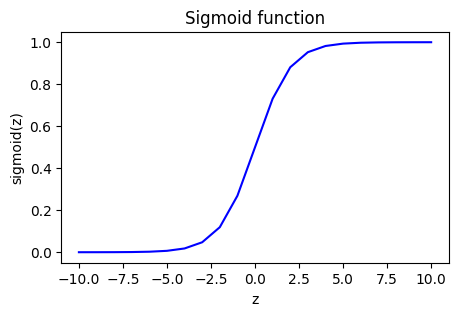

In [54]:
# Test the gradient implementation using the finite diff method provided

# first test the sigmoid function
# Generate an array of evenly spaced values between -10 and 10
z_tmp = np.arange(-10,11)

# Use the function implemented above to get the sigmoid values
sig = sigmoid(z_tmp)

# Code for pretty printing the two arrays next to each other
np.set_printoptions(precision=3) 
print("Input (z), Output (sigmoid(z))")
print(np.c_[z_tmp, sig])

import matplotlib.pyplot as plt
# Plot z vs sigmoid(z)
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(z_tmp, sig, c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
#draw_vthresh(ax,0)



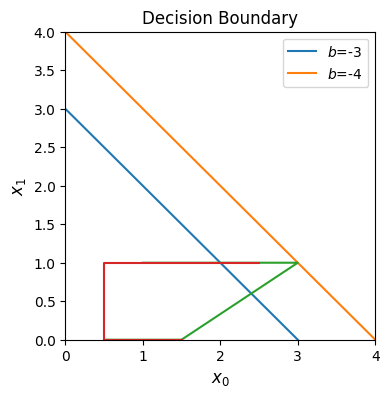

In [59]:
# Choose values between 0 and 6
x0 = np.arange(0,6)

# Plot the two decision boundaries
x1 = 3 - x0
x1_other = 4 - x0

fig,ax = plt.subplots(1, 1, figsize=(4,4))
# Plot the decision boundary
ax.plot(x0,x1, label="$b$=-3")
ax.plot(x0,x1_other,  label="$b$=-4")
ax.axis([0, 4, 0, 4])

# Plot the original data
plt.plot(X,y)
ax.axis([0, 4, 0, 4])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.legend(loc="upper right")
plt.title("Decision Boundary")
plt.show()

In [61]:
w_array1 = np.array([1,1])
b_1 = -3
w_array2 = np.array([1,1])
b_2 = -4

print("Cost for b = -3 : ", cross_entropy_loss_with_gradient(X, y, w_array1, b_1))
print("Cost for b = -4 : ", cross_entropy_loss_with_gradient(X, y, w_array2, b_2))

ValueError: shapes (2,) and (6,2) not aligned: 2 (dim 0) != 6 (dim 0)

In [ ]:
# Test the gradient
# Setting function to be logistic regression model with sigmoid function 

fdg = finite_difference_gradient(sigmoid, initial=w)

In [ ]:
def logistic_regression_train(X, y, lr, tol= 1e-5, maxIters= 2000):
    n, d = X.shape 
    # initialise w0, b0
    # w0 = np.zeros(d)
    # b0 = 0.0
    losses = []
    # loop until converge
    for i in range(maxIters):
        ## Implement gradient descent here
        w0 = w0
        # Check convergence here 
        # if True:
        #    break
    return w0, b0, losses

After you finish implementing all the above methods, use your learning algorithm to train a logistic regression model on the training dataset and answer the following questions:

* plot the learning curve
* report the learnt parameter with a learning rate 0.1, `tol=1e-5` and `maxIters=2000`
* report the classification accuracy on the test dataset

In [ ]:
## run your algorithm and report your findings
d2_w0, d2_b0, d2_losses  = logistic_regression_train(d2_xtrain, d2_ytrain, 0.1)

(2001,)


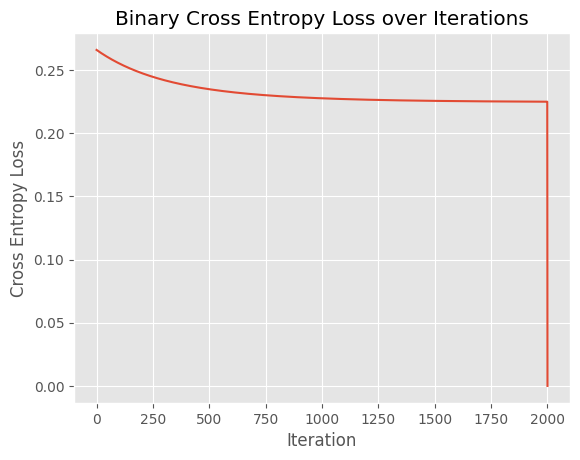

w0:  [ 0.57226717 -0.54359379  2.15775387 -0.04094687]
b0:  0.0
[ 0.9569717   1.13272534 -1.53448231 ... -2.48027552 -0.02570073
  0.04580934]


In [ ]:
# plot the losses over iterations
print(d2_losses.shape)
plt.figure()
plt.plot(d2_losses)
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.title('Binary Cross Entropy Loss over Iterations')
plt.grid(True)
plt.show()
# report the learnt parameter 
print("w0: ", d2_w0)
print("b0: ", d2_b0)

In [ ]:
# classification accuracy
d2_train_pred = d2_xtrain @ d2_w0
train_acc = (d2_ytrain == d2_train_pred).sum() / 1500
print("Training accuracy: ", train_acc)
# d2_test_pred = # make predictions using test dataset
# test_acc = (d2_xtrain == d2_test_pred).sum() / N

[1. 1. 0. ... 0. 0. 0.]
Training accuracy:  0.0


### Task 2.2 Regularisation

In this sub-task, you are going to apply $L_2$ regularisation to the logistic regression model. The regularised loss is

$$
L(\mathbf{w}, b)= - \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \ln \sigma^{(i)}+ (1- y^{(i)}) \ln (1-\sigma^{(i)}) + \frac{\lambda}{2} \|\mathbf{w}\|_2^2
$$

* where $\lambda >0$ is the regularisation hyperparameter

* note that we do not usually apply penalty on the bias parameter $b$

Implement the following method that fits a regularised logistic regression model with a given $\lambda$.

In [ ]:
def logistic_regression_reg_train(X, y, lr, lam = 0.01, tol= 1e-5, maxIters= 2000):
    n, d = X.shape 
    # initialise w0, b0
    w0 = np.zeros(d)
    b0 = 0.0
    losses = []
    # loop until converge
    # for i in range(maxIters):
        
    # return w0, b0, losses

Complete and report the following two results
* report the training loss and learnt parameter by setting $\lambda=0.01$
* report the testing performance for the regularised logistic regression model with $\lambda=0.01$

In [ ]:
## run your algorithm and report your findings

### Task 2.3 Newton's method (extension)

For convex loss functions, Newton's method converges much faster than a simple gradient descent algorithm. Implement a learning algorithm for the regularised logsitic regression with Newton's method. You are allowed to use auto-diff to finish this task.


* use Newton's method to find the same logistic regression model

* compare with gradient descent's learning curve, what do you observe?

In [ ]:
## run Newton's method 

In [ ]:
## report your findings

### Task 2.4 Weighted logistic regression (extension)

Weighted logistic regression is a variant of the traditional logistic regression. It is usually used when the classification dataset is imbalanced. By assigning higher weights to the minority class and lower weights to the majority class, the model is encouraged to pay more attention to the minority class.

Specifically, each training instance $y^{(i)}$ is given a positive weight $r^{(i)}$, and the weighted cross entropy loss becomes 

$$L(\mathbf{w}, b) = - \frac{1}{\sum_{i=1}^n r^{(i)}} \sum_{i=1}^n r^{(i)}\cdot \left ( {y^{(i)}} \ln \sigma^{(i)}+ (1- y^{(i)}) \ln (1-\sigma^{(i)}) \right ) + \frac{\lambda}{2} \|\mathbf{w}\|_2^2$$

We can for example use the relative frequency of the training data to set $r^{(i)}$. Let $n^+ = \sum_{i=1}^n y^{(i)}$ and $n^- = n - n^+$ be the number of positive and negative training instances respectively in the training data. The weights can be set as 

$$r^{(i)} = \begin{cases}\frac{n}{n^-} & y^{(i)} = 0 \\ \frac{n}{n^+} & y^{(i)} =1\end{cases}$$



* derive and write down the gradient of the weighted loss w.r.t the learning parameter

* implement a suitable training algorithm to learn the parameter

* report the learnt parameter with $\lambda =0.1$

In [ ]:
## gradient expression here

In [ ]:
## Implement and run your algorithm and report your findings

## Submission
Hand in via MMS: the completed jupyter notebook. Your notebook should be reproducible. 



## Marking
Your submission will be marked as a whole. 

* to get a grade above 7, you are expected to finish at least Task 1.1 to a good standard
* to get a grade above 10 and up to 13, you are expected to complete Task 1.1-1.2 and Task 2.1 to a good standard
* to get a grade above 13 and up to 17, you are expected to complete all tasks except 2.3 and 2.4 a good standard
* to achieve a grade of 17+, you are expected to finish all tasks well
* to get 18+, you are expected to attempt all questions flawlessly


## Policies

* See the Generic Mark Descriptors in the School Student Handbook: 

  [http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#Mark_Descriptors](http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#Mark_Descriptors)


* The standard penalty for late submission applies (Scheme A: 1 mark per 24 hour period, or part thereof):
  
  [http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/assessment.html#lateness-penalties](http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/assessment.html#lateness-penalties)


* The University policy on Good Academic Practice applies:

  [https://www.st-andrews.ac.uk/students/rules/academicpractice/](https://www.st-andrews.ac.uk/students/rules/academicpractice/)